In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from esn_module import esn

from echo_state_tests import gen_in_out_one_in_subs, test_XOR

from scipy.sparse import csr_matrix

/home/fschubert/work/py36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [42]:
class RNN:
    
    def __init__(self,
                N=1000,
                cf=.1,
                cf_w_in=.1,
                sigm_w=1.,
                sigm_w_in=1.,
                sigm_w_out_init=.1,
                tau=1.,
                data_dim_in=1,
                data_dim_out=1,
                eps_a=0.0001):
        
        self.N = N
        
        self.W = np.random.normal(0.,sigm_w/(N*cf)**.5,(N,N))*(np.random.rand(N,N) <= cf)
        self.W[range(N),range(N)] = 0.
        
        self.cf = (1.*(self.W!=0.)).sum()/N**2.
        
        self.Wt = self.W.T
        
        if self.cf < .5:
            self.W = csr_matrix(self.W)
            self.sparse_W = True
        else:
            self.sparse_W = False
            
        self.data_dim_in = data_dim_in
        self.data_dim_out = data_dim_out
        
        self.w_in = np.random.normal(0.,sigm_w_in,(self.N,self.data_dim_in))*(np.random.rand(self.N,self.data_dim_in) <= cf_w_in)
        
        self.cf_w_in = (1.*(self.w_in!=0.)).sum()/(N*data_dim_in)
        
        self.w_out = np.random.rand(data_dim_out,self.N+1)-.5
        self.w_out[:,0] = 0.
        
        self.tau = tau
        
        self.a = np.ones(self.N)
        
        self.eps_a = eps_a
    
    def check_data_in_comp(self,data):

        if len(data.shape)==1:
            if self.data_dim_in != 1:
                print("input dimensions do not fit!")
                sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.data_dim_in):
            print("input dimensions do not fit!")
            sys.exit()

        return data
    
    def check_data_out_comp(self,data):

        if len(data.shape)==1:
            if self.data_dim_out != 1:
                print("output dimensions do not fit!")
                #sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.data_dim_out):
            print("output dimensions do not fit!")
            #sys.exit()

        return data
    
    def learn_gain(self,
                    u_in,
                    u_out,
                   mode,
                  T_batch_w_out=None,
                    tau_batch_w_out = 1.,
                    reg_fact = 0.01,
                  T_skip_rec=10,
                              show_progress=True,
                  return_y = True,
                  return_X = True,
                  return_X_r = True,
                  return_X_e = True,
                  return_a = True,
                  return_dyda = True,
                  return_delta_a = True,
                  return_w_out = True,
                  return_Err = True,
                return_W = True):
    
    

    
    
        modelist = ["local_grad_local_gain",
                        "local_grad_global_gain",
                        "global_grad_local_gain",
                        "global_grad_global_gain"]
        
        if not(mode in modelist):
            print("wrong mode argument!")
            return None
        else:
            mode = modelist.index(mode)
        
        if T_batch_w_out == None:
            T_batch_w_out = self.N*4
        
        u_in = self.check_data_in_comp(u_in)
        u_out = self.check_data_out_comp(u_out)
        
        if u_in.shape[0] == u_out.shape[0]:
            T = u_in.shape[0]
        else:
            print("length of time series do not match!")
        
        ### recording
        
        T_rec = int(T/T_skip_rec)
        
        
        if return_y:
            y_rec = np.ndarray((T_rec,self.N))
        if return_X_r:
            X_r_rec = np.ndarray((T_rec,self.N))
        if return_X_e:
            X_e_rec = np.ndarray((T_rec,self.N))
        if return_X:
            X_rec = np.ndarray((T_rec,self.N))
        if return_a:
            a_rec = np.ndarray((T_rec,self.N))
        if return_dyda:
            if mode == 0:
                dyda_rec = np.ndarray((T_rec,self.N,self.N))
            if mode == 1:
                dyda_rec = np.ndarray((T_rec,self.N))
            if mode == 2:
                dyda_rec = np.ndarray((T_rec,self.N,self.N))
            if mode == 3:
                dyda_rec = np.ndarray((T_rec,self.N))
        if return_delta_a:
            if mode == 0:
                delta_a_rec = np.ndarray((T_rec,self.N))
            if mode == 1:
                delta_a_rec = np.ndarray((T_rec))
            if mode == 2:
                delta_a_rec = np.ndarray((T_rec,self.N))
            if mode == 3:
                delta_a_rec = np.ndarray((T_rec))
        if return_w_out:
            w_out_rec = np.ndarray((T_rec,self.data_dim_out,self.N+1))
        if return_Err:
            Err_rec = np.ndarray((T_rec))
               
        
        if mode == 0:
            dyda = np.zeros((self.N,self.N))
            delta_a = np.zeros((self.N))
               
        if mode == 1:
            dyda = np.zeros((self.N))
            delta_a = 0.
               
        if mode == 2:
            dyda = np.zeros((self.N,self.N))
            delta_a = np.zeros((self.N))

        if mode == 3:
            dyda = np.zeros((self.N))
            delta_a = 0.            
        
        
        err = np.ndarray((1,self.data_dim_out))
        
        y_rec_w_out_learn = np.zeros((T_batch_w_out,self.N+1))

        u_out_w_out_learn = np.zeros((T_batch_w_out,self.data_dim_out))
        ###
        
        y = np.random.rand(self.N+1)-.5
        y[0] = 0.
        
        
        
        for t in tqdm(range(T),disable=not(show_progress)):
            
            X_r = self.W.dot(y[1:])
            
            X_e = self.w_in.dot(u_in[t,:])
            
            X = X_r + X_e
            
            #y[1:] = np.tanh(self.a*X_r + X_e)
            
            y[1:] = np.tanh(self.a*X)
            
            y_rec_w_out_learn[t%T_batch_w_out,:] = y[:]

            u_out_w_out_learn[t%T_batch_w_out,:] = u_out[t,:]
            
            O = self.w_out.dot(y)
            
            
            if t%T_batch_w_out == 0 and t>0.:
                
                self.w_out = self.w_out + (1./tau_batch_w_out)*( -self.w_out + (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(self.N+1)) @ y_rec_w_out_learn.T @ u_out_w_out_learn).T)
                   
            err[0,:] = O - u_out[t,:]
            
            
            
            if mode == 0:
                dyda[range(self.N),range(self.N)] = (1.-y[1:]**2.)*X
            
            if mode == 1:
                dyda = (1.-y[1:]**2.)*X
                
            if mode == 2:
                
                dyda = (self.Wt*(1.-y[1:]**2.)*self.a).T @ dyda
                
                dyda[range(self.N),range(self.N)] += (1.-y[1:]**2.)*X
            if mode == 3:
                dyda = (1.-y[1:]**2.)*(X + self.a[0]*self.W.dot(dyda))
             
            
            if t >= T_batch_w_out:
                                                
                if mode == 0 or mode == 2:
                    delta_a = -err.dot(self.w_out[:,1:].dot(dyda))[0,:]
                else:
                    delta_a = -err.dot(self.w_out[:,1:].dot(dyda))
                               
                self.a += self.eps_a*delta_a

                self.a = np.maximum(0.01,self.a)
            
            
            ### recording
            
            if t%T_skip_rec == 0:
                
                t_rec = int(t/T_skip_rec)
                
                y_rec[t_rec,:] = y[1:]
                
                if return_X:
                    X_rec[t_rec,:] = X                
                if return_X_r:                
                    X_r_rec[t_rec,:] = X_r
                if return_X_e:
                    X_e_rec[t_rec,:] = X_e
                
                if mode == 0 or mode == 2:
                    if return_dyda:
                        dyda_rec[t_rec,:,:] = dyda
                    if return_delta_a:
                        delta_a_rec[t_rec,:] = delta_a
                    
                else:
                    if return_dyda:
                        dyda_rec[t_rec,:] = dyda
                    if return_delta_a:
                        delta_a_rec[t_rec] = delta_a                
                
                if return_a:
                    a_rec[t_rec,:] = self.a[:]
                
                if return_Err:
                    Err_rec[t_rec] = .5*(err**2.).sum()
                if return_w_out:
                    w_out_rec[t_rec,:,:] = self.w_out
                
        t_ax = np.array(range(T_rec))*T_skip_rec
        
        result = [t_ax]
        
        if return_y:
            result.append(y_rec)
        if return_X:
            result.append(X_r_rec+X_e_rec)
        if return_X_r:
            result.append(X_r_rec)
        if return_X_e:
            result.append(X_e_rec)
        if return_a:
            result.append(a_rec)
        if return_dyda:
            result.append(dyda_rec)
        if return_delta_a:
            result.append(delta_a_rec)
        if return_w_out:
            result.append(w_out_rec)
        if return_Err:
            result.append(Err_rec)
        if return_W:
            result.append(np.array(self.W.todense()))
              
        return result
        
        
    
    def learn_w_out(self,u_in,u_target,reg_fact=0.01,t_prerun=0):

        u_in = self.check_data_in_comp(u_in)
        u_target = self.check_data_out_comp(u_target)

        n_t = u_in.shape[0]

        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.


        y[0,1:] = np.tanh(self.w_in @ u_in[0,:])


        for t in tqdm(range(1,n_t)):

            y[t,1:] = np.tanh(self.a*self.W.dot(y[t-1,1:]) + self.w_in @ u_in[t,:])
        
        self.w_out[:,:] = (np.linalg.inv(y[t_prerun:,:].T @ y[t_prerun:,:] + reg_fact*np.eye(self.N+1)) @ y[t_prerun:,:].T @ u_target[t_prerun:,:]).T
    
    def predict_data(self,data,return_reservoir_rec=False):

        data = self.check_data_in_comp(data)

        n_t = data.shape[0]

        u_in = data

        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.

        y[0,1:] = np.tanh(self.w_in @ u_in[0,:])

        for t in tqdm(range(1,n_t)):

            y[t,1:] = np.tanh(self.a*self.W.dot(y[t-1,1:]) + self.w_in @ u_in[t,:])

        out = (self.w_out @ y.T).T
        if self.data_dim_out == 1:
            out = out[:,0]

        if return_reservoir_rec:
            return (out,y)
        else:
            return out


In [187]:
tau_max = 25

tau_delay = np.arange(tau_max)
gain = np.ndarray((tau_max))

MC = np.ndarray((tau_max))

for k,tau in tqdm(enumerate(tau_delay)):

    rnn = RNN(N=500)

    u_in,u_out = gen_in_out_one_in_subs(1500000,tau)

    t,y,a,w_out,E = rnn.learn_global_gain_RTRL(u_in,u_out,tau_batch_w_out=1.)
    
    gain[k] = a[-1]
    
    u_in_learn,u_out_learn = gen_in_out_one_in_subs(10000,tau)
    u_in_test,u_out_test = gen_in_out_one_in_subs(10000,tau)

    rnn.learn_w_out(u_in_learn,u_out_learn)

    u_out_pred = rnn.predict_data(u_in_test)
    
    MC[k] = np.corrcoef(u_out_test,u_out_pred)[0,1]**2.
    
    

In [188]:
gain_local = np.ndarray((tau_max))
MC_local = np.ndarray((tau_max))


for k,tau in tqdm(enumerate(tau_delay)):

    rnn = RNN(N=500)

    u_in,u_out = gen_in_out_one_in_subs(1500000,tau)

    t,y,a,w_out,E = rnn.learn_global_gain_Local(u_in,u_out,tau_batch_w_out=1.)
    
    gain_local[k] = a[-1]
    
    u_in_learn,u_out_learn = gen_in_out_one_in_subs(10000,tau)
    u_in_test,u_out_test = gen_in_out_one_in_subs(10000,tau)

    rnn.learn_w_out(u_in_learn,u_out_learn)

    u_out_pred = rnn.predict_data(u_in_test)
    
    MC_local[k] = np.corrcoef(u_out_test,u_out_pred)[0,1]**2.

In [9]:
textwidth = 5.5532
path = "../plots/RTRL/"

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

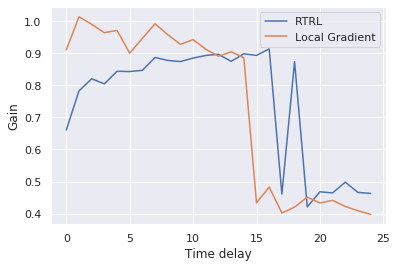

In [3]:
'''
np.save("tau_delay.np",tau_delay)
np.save("gain.np",gain)
np.save("gain_local.np",gain_local)
'''
tau_delay = np.load("tau_delay.np.npy")
gain = np.load("gain.np.npy")
gain_local=np.load("gain_local.np.npy")

plt.plot(tau_delay,gain,label='RTRL')
plt.plot(tau_delay,gain_local,label='Local Gradient')
plt.xlabel("Time delay")
plt.ylabel("Gain")
plt.legend()
plt.show()

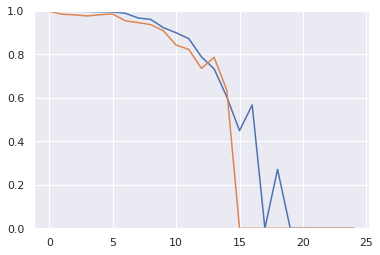

In [4]:
'''
np.save("MC.np",MC)
np.save("MC_local.np",MC_local)
'''

MC = np.load("MC.np.npy")
MC_local = np.load("MC_local.np.npy")

plt.plot(tau_delay,MC)
plt.plot(tau_delay,MC_local)
plt.ylim([0.,1.])
plt.show()

In [161]:
rnn = RNN(N=500)
rnn.a *= 0.5
rnn_RTRL = RNN(N=500)
rnn_RTRL.eps_a *= 0.5

u_in,u_out = gen_in_out_one_in_subs(1500000,5)

t,y,X_r,X_e,a,dyda,dyda_approx,delta_a,delta_a_approx,w_out,E,W = rnn.learn_global_gain_Local(u_in,u_out,tau_batch_w_out=1.,T_skip_rec=100)
t,y_RTRL,X_r_RTRL,X_e_RTRL,a_RTRL,dyda_RTRL,dyda_approx_RTRL,delta_a_RTRL,delta_a_approx_RTRL,w_out_RTRL,E_RTRL,W_RTRL = rnn_RTRL.learn_global_gain_RTRL(u_in,u_out,tau_batch_w_out=1.,T_skip_rec=100)

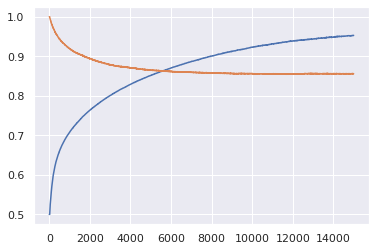

In [162]:
plt.plot(a)
plt.plot(a_RTRL)
plt.show()

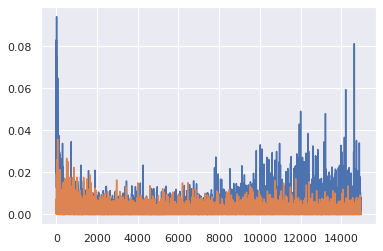

In [167]:
plt.plot(E[50:])
plt.plot(E_RTRL[50:])
plt.show()

In [103]:
n_samples = 5

n_sweep = 50

gain_arr = np.linspace(0.2,1.5,n_sweep)
tau_arr = np.array([1,5,10,15])

delta_a_global_mean_RTRL_global = np.ndarray((n_samples,tau_arr.shape[0],n_sweep))
delta_a_global_mean_RTRL_local = np.ndarray((n_samples,tau_arr.shape[0],n_sweep))


for s in tqdm(range(n_samples)):

    for n in tqdm(range(tau_arr.shape[0])):

        for k in tqdm(range(n_sweep)):
            
            ### Global Gradient
            rnn = RNN(N=500)
            rnn.a = np.ones((500))*gain_arr[k]
            rnn.eps_a = 0.

            u_in,u_out = gen_in_out_one_in_subs(10000,tau_arr[n])
            
            #'''
            t,y,X,X_r,X_e,a,delta_a,w_out,E,W = rnn.learn_gain(u_in,u_out,mode='global_grad_global_gain',
                                                               tau_batch_w_out=1.,T_skip_rec=1,
                                                               show_progress=False,return_dyda=False)
                        
            delta_a_global_mean_RTRL_global[s,n,k] = delta_a[rnn.N*4:].mean(axis=0)
            ###
            
            
            ### Local Gradient
            rnn = RNN(N=500)
            rnn.a = np.ones((500))*gain_arr[k]
            rnn.eps_a = 0.

            u_in,u_out = gen_in_out_one_in_subs(10000,tau_arr[n])
            
            #'''
            t,y,X,X_r,X_e,a,delta_a,w_out,E,W = rnn.learn_gain(u_in,u_out,mode='local_grad_global_gain',
                                                               tau_batch_w_out=1.,T_skip_rec=1,
                                                               show_progress=False,return_dyda=False)
            delta_a_global_mean_RTRL_local[s,n,k] = delta_a[rnn.N*4:].mean(axis=0)
            ###

np.save("delta_a_global_mean_RTRL_global",delta_a_global_mean_RTRL_global)
np.save("delta_a_global_mean_RTRL_local",delta_a_global_mean_RTRL_local)

KeyboardInterrupt: 

NameError: name 'delta_a_mean' is not defined

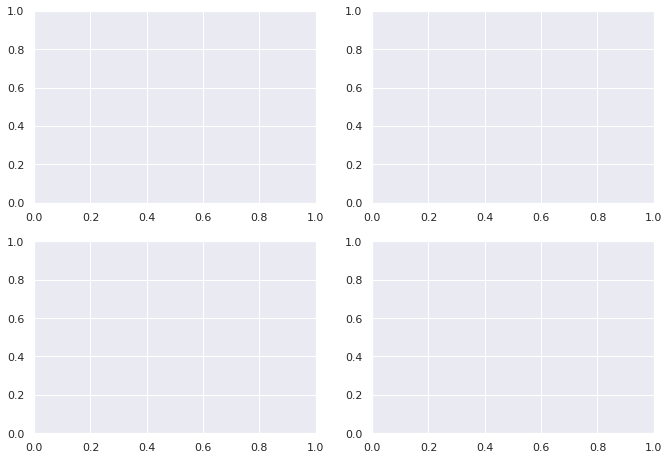

In [61]:
fig, ax = plt.subplots(2,2,figsize=(2.*textwidth,2.*textwidth*0.7))
for k in range(4):
    ax[int(k/2),k%2].plot(gain_arr,delta_a_mean[:,k,:].mean(axis=0)*7.,c=colors[0],label="approximate local Gradient (scale adjusted)")
    ax[int(k/2),k%2].plot(gain_arr,delta_a_RTRL_mean[:,k,:].mean(axis=0),'--',c=colors[0],label="full (RTRL) Gradient")
    ax[int(k/2),k%2].set_ylabel("$\\Delta a$")
    ax[int(k/2),k%2].set_xlabel("$a$")
    
    
    ax[int(k/2),k%2].set_title("$\\tau = " + str(tau_arr[k]) + "$")

ax[0,0].legend()
    
ax[0,0].set_ylim([-.5,.5])
ax[0,1].set_ylim([-1.,1.])
ax[1,0].set_ylim([-1.,.75])
ax[1,1].set_ylim([-1.,.5])

plt.tight_layout()

fig.savefig(path+"gain_dyn.pdf")

plt.show()

In [46]:
rnn = RNN(N=500)
rnn.a *= .6
rnn.eps_a *= 50.
u_in,u_out = gen_in_out_one_in_subs(5000,5)

'''
modelist = ["local_grad_local_gain",
                        "local_grad_global_gain",
                        "global_grad_local_gain",
                        "global_grad_global_gain"]
'''

t,y,X,X_r,X_e,a,dyda,delta_a,w_out,E,W = rnn.learn_gain(u_in,u_out,mode='global_grad_local_gain',tau_batch_w_out=1.,T_skip_rec=50,show_progress=True)

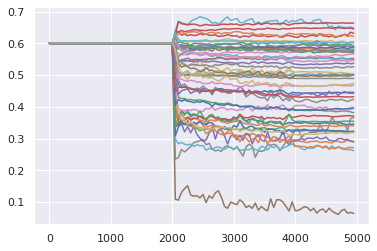

In [47]:
plt.plot(t,a[:,:50])
plt.show()

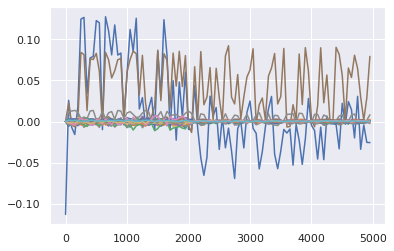

In [48]:
plt.plot(t,dyda[:,0,:50])
plt.show()

In [53]:
n_samples = 5

n_sweep = 50

gain_arr = np.linspace(0.2,1.5,n_sweep)
tau_arr = np.array([1,5,10,15])

delta_a_local_mean_RTRL_global = np.ndarray((n_samples,tau_arr.shape[0],n_sweep))
delta_a_local_mean_RTRL_local = np.ndarray((n_samples,tau_arr.shape[0],n_sweep))


for s in tqdm(range(n_samples)):

    for n in tqdm(range(tau_arr.shape[0])):

        for k in tqdm(range(n_sweep)):
            
            ### Global Gradient
            rnn = RNN(N=500)
            rnn.a = np.ones((500))*gain_arr[k]
            rnn.eps_a = 0.

            u_in,u_out = gen_in_out_one_in_subs(10000,tau_arr[n])
            
            #'''
            t,y,X,X_r,X_e,a,delta_a,w_out,E,W = rnn.learn_gain(u_in,u_out,mode='global_grad_local_gain',
                                                               tau_batch_w_out=1.,T_skip_rec=1,
                                                               show_progress=False,return_dyda=False)
            delta_a_local_mean_RTRL_global[s,n,k] = (delta_a[rnn.N*4:,:].mean(axis=0)*rnn.a).sum()/(rnn.a**2.).sum()**.5
            ###
            
            
            ### Local Gradient
            rnn = RNN(N=500)
            rnn.a = np.ones((500))*gain_arr[k]
            rnn.eps_a = 0.

            u_in,u_out = gen_in_out_one_in_subs(10000,tau_arr[n])
            
            #'''
            t,y,X,X_r,X_e,a,delta_a,w_out,E,W = rnn.learn_gain(u_in,u_out,mode='local_grad_local_gain',
                                                               tau_batch_w_out=1.,T_skip_rec=1,
                                                               show_progress=False,return_dyda=False)
            delta_a_local_mean_RTRL_local[s,n,k] = (delta_a[rnn.N*4:,:].mean(axis=0)*rnn.a).sum()/(rnn.a**2.).sum()**.5
            ###

np.save("delta_a_local_mean_RTRL_global",delta_a_local_mean_RTRL_global)
np.save("delta_a_local_mean_RTRL_local",delta_a_local_mean_RTRL_local)

In [62]:
np.save("delta_a_local_mean_RTRL_global",delta_a_local_mean_RTRL_global)
np.save("delta_a_local_mean_RTRL_local",delta_a_local_mean_RTRL_local)

/home/fschubert/work/py36/lib/python3.6/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


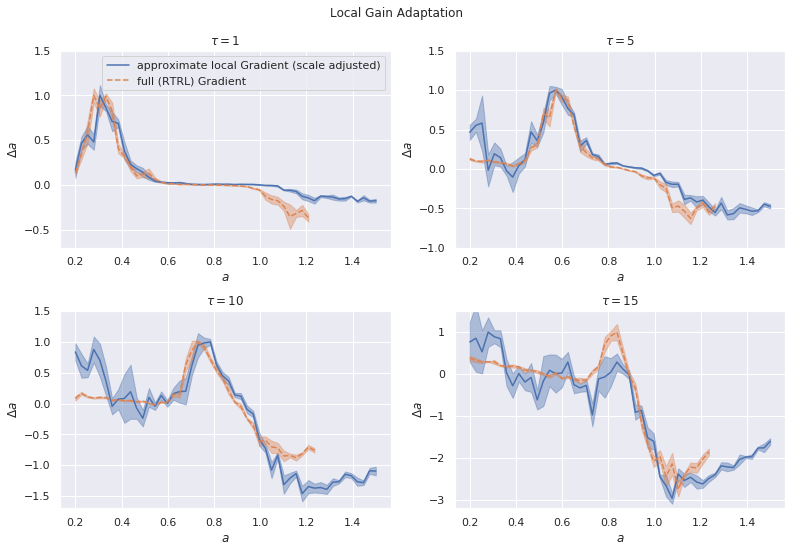

In [98]:
fig, ax = plt.subplots(2,2,figsize=(2.*textwidth,2.*textwidth*0.7))

fig.suptitle("Local Gain Adaptation",fontsize=12)

for k in range(4):
    mean_RTRL_local = delta_a_local_mean_RTRL_local[:,k,:].mean(axis=0)
    mean_RTRL_global = delta_a_local_mean_RTRL_global[:,k,:].mean(axis=0)
    
    err_RTRL_local = delta_a_local_mean_RTRL_local[:,k,:].std(axis=0)/delta_a_local_mean_RTRL_local.shape[0]**.5
    err_RTRL_global = delta_a_local_mean_RTRL_global[:,k,:].std(axis=0)/delta_a_local_mean_RTRL_global.shape[0]**.5
    
    idx_local = np.where(np.abs(mean_RTRL_local) < 1.)
    idx_global = np.where(np.abs(mean_RTRL_global) < 1.)
    
    mean_RTRL_local = mean_RTRL_local[idx_local]
    mean_RTRL_global = mean_RTRL_global[idx_global]
    
    err_RTRL_local = err_RTRL_local[idx_local]
    err_RTRL_global = err_RTRL_global[idx_global]
        
    err_RTRL_local /= mean_RTRL_local.max()
    err_RTRL_global /= mean_RTRL_global.max()
    
    mean_RTRL_local /= mean_RTRL_local.max()
    mean_RTRL_global /= mean_RTRL_global.max()
   
    
    ax[int(k/2),k%2].fill_between(gain_arr[idx_local],(mean_RTRL_local - err_RTRL_local),(mean_RTRL_local + err_RTRL_local),
                                  color=colors[0],alpha=0.4)
    ax[int(k/2),k%2].plot(gain_arr[idx_local],mean_RTRL_local,c=colors[0],label="approximate local Gradient (scale adjusted)")
    
    
    
    
    ax[int(k/2),k%2].fill_between(gain_arr[idx_global],(mean_RTRL_global - err_RTRL_global),(mean_RTRL_global + err_RTRL_global),
                                  color=colors[1],alpha=0.4)
    
    ax[int(k/2),k%2].plot(gain_arr[idx_global],mean_RTRL_global,'--',c=colors[1],label="full (RTRL) Gradient")
    ax[int(k/2),k%2].set_ylabel("$\\Delta a$")
    ax[int(k/2),k%2].set_xlabel("$a$")
    
    
    ax[int(k/2),k%2].set_title("$\\tau = " + str(tau_arr[k]) + "$")

ax[0,0].legend()

'''
ax[0,0].set_ylim([-.04,.07])
ax[0,1].set_ylim([-.04,.07])
ax[1,0].set_ylim([-.04,.07])
ax[1,1].set_ylim([-.04,.07])
'''

ax[0,0].set_ylim([-.7,1.5])
ax[0,1].set_ylim([-1.,1.5])
ax[1,0].set_ylim([-1.7,1.5])
ax[1,1].set_ylim([-3.2,1.5])


plt.tight_layout(rect=[0., 0., 1., .95])

fig.savefig(path+"local_gain_dyn.pdf")

plt.show()

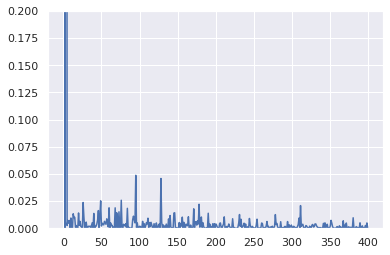

In [20]:
plt.plot(E)
plt.ylim([0.,.2])
plt.show()

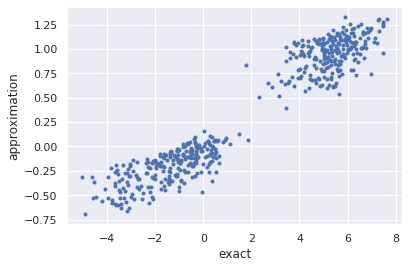

In [148]:
tstart = 4000
tend = tstart + 500

plt.plot(scalprod_dyda_w_out[tstart:tend],scalprod_dyda_approx_w_out[tstart:tend],'.')
plt.xlabel("exact")
plt.ylabel("approximation")
plt.show()

In [129]:
dyda_RTRL.shape

(15000, 500)

In [22]:
y.shape

(15000, 500)

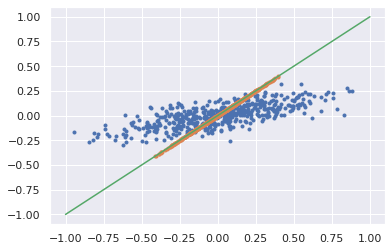

In [75]:
plt.plot(dyda_RTRL[-10000:,:].mean(axis=0),((1.-y_RTRL**2.)*X_r_RTRL)[-10000:,:].mean(axis=0),'.')
plt.plot(dyda[-10000:,:].mean(axis=0),((1.-y**2.)*X_r)[-10000:,:].mean(axis=0),'.')
plt.plot([-1.,1.],[-1.,1.])
plt.show()

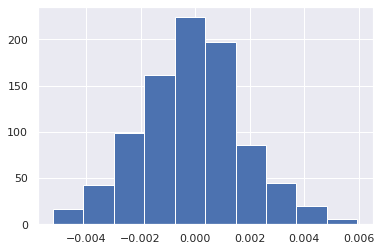

0.044686571081459674


In [30]:
plt.hist(W_RTRL.mean(axis=1),density=True)
plt.show()
print(W_RTRL.std())

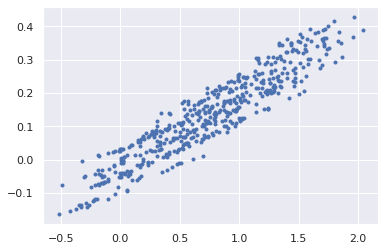

In [123]:
tstart = 1500
tend = tstart + 500
k = 499
plt.plot(dyda_RTRL[tstart:tend,k],dyda_approx_RTRL[tstart:tend,k],'.')
#plt.plot([delta_a_RTRL[tstart:tend].mean()],[delta_a_approx_RTRL[tstart:tend].mean()],'.')
#plt.plot(t[tstart:tend],delta_a_RTRL[tstart:tend],'.')
#plt.plot(t[tstart:tend],delta_a_approx_RTRL[tstart:tend]*4.,'.')
#plt.plot([delta_a_RTRL[tstart:tend].min(),delta_a_RTRL[tstart:tend].max()],[delta_a_RTRL[tstart:tend].min(),delta_a_RTRL[tstart:tend].max()])
plt.show()

#print("true delta a mean: " + str(delta_a_RTRL[tstart:tend].mean()))
#print("approx. delta a mean: " + str(delta_a_approx_RTRL[tstart:tend].mean()))

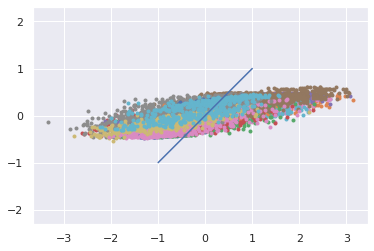

In [71]:
for k in range(20):
    plt.plot(dyda_RTRL[:500,k],((1.-y_RTRL**2.)*(X_r_RTRL))[:500,k],'.')
#plt.plot(dyda[-500:,k],((1.-y**2.)*X_r)[-500:,k],'.')
plt.plot([-1.,1.],[-1.,1.])
plt.axis("equal")
plt.show()

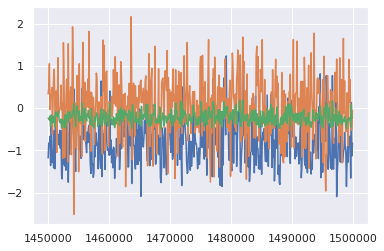

In [54]:
k=1
plt.plot(t[-500:],dyda_RTRL[-500:,k])
plt.plot(t[-500:],(1.-y_RTRL[-500:,k]**2.)*a_RTRL[-1]*W_RTRL.dot(dyda_RTRL[-500:,k].T).T)
plt.plot(t[-500:],(1.-y_RTRL[-500:,k]**2.)*X_r_RTRL[-500:,k])
plt.show()

In [176]:
u_in_learn,u_out_learn = gen_in_out_one_in_subs(10000,5)
u_in_test,u_out_test = gen_in_out_one_in_subs(10000,5)

rnn.learn_w_out(u_in_learn,u_out_learn)
rnn_RTRL.learn_w_out(u_in_learn,u_out_learn)

u_out_pred = rnn.predict_data(u_in_test)
u_out_pred_RTRL = rnn_RTRL.predict_data(u_in_test)

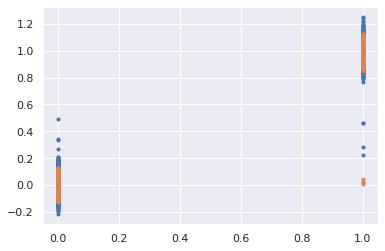

In [177]:
plt.plot(u_out_test,u_out_pred,'.')
plt.plot(u_out_test,u_out_pred_RTRL,'.')
plt.show()

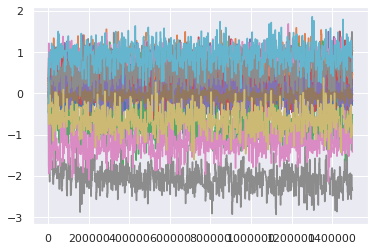

In [139]:
plt.plot(t,w_out[:,0,:20])
plt.show()